In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [2]:
df=pd.read_csv('anime project.csv')
df

,anime_name,anime_id,type,episodes,score,rank,popularity,scored_by,likes,aired_from,aired_to,duration,Storyline
0,Cowboy Bebop,1,TV,26.0,8.77,32.0,44,713379.0,64780,1998-04-03T00:00:00+00:00,1999-04-24T00:00:00+00:00,24 min per ep,"In the year 2071, humanity has colonized sever..."
1,Cowboy Bebop: Tengoku no Tobira,5,Movie,1.0,8.38,170.0,552,178460.0,1155,2001-09-01T00:00:00+00:00,NaN,1 hr 55 min,"Another day, another bounty—such is the life o..."
2,Trigun,6,TV,26.0,8.22,300.0,228,301980.0,12438,1998-04-01T00:00:00+00:00,1998-09-30T00:00:00+00:00,24 min per ep,"Vash the Stampede is the man with a $$60,000,0..."
3,Witch Hunter Robin,7,TV,26.0,7.26,2637.0,1605,37883.0,534,2002-07-02T00:00:00+00:00,2002-12-24T00:00:00+00:00,25 min per ep,Witches are individuals with special powers li...
4,Bouken Ou Beet,8,TV,52.0,6.96,3925.0,4651,5547.0,13,2004-09-30T00:00:00+00:00,2005-09-29T00:00:00+00:00,23 min per ep,It is the dark century and the people are suff...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2621,Rosario to Vampire,2993,TV,13.0,6.79,4647.0,241,346017.0,3129,2008-01-03T00:00:00+00:00,2008-03-27T00:00:00+00:00,25 min per ep,Youkai Academy is a seemingly normal boarding ...
2622,Death Note: Rewrite,2994,Special,2.0,7.69,1087.0,1020,77166.0,466,2007-08-31T00:00:00+00:00,2008-08-22T00:00:00+00:00,1 hr 52 min per ep,1. Genshisuru Kami (Visions of a God) A two ho...
2623,Hi no Tori: Houou-hen,2997,Movie,1.0,6.86,4346.0,8364,1159.0,5,1986-12-20T00:00:00+00:00,NaN,1 hr,"Akanemaru, a skilled sculptor, sets out to fin..."
2624,Hi no Tori: Uchuu-hen,2998,OVA,1.0,6.94,4021.0,8822,948.0,4,1987-12-21T00:00:00+00:00,NaN,48 min,"In deep space, four astronauts discover that t..."


In [3]:
MVpercentages = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)
print(MVpercentages.head(10))

aired_to      0.320259
rank          0.087205
Storyline     0.007616
score         0.004570
scored_by     0.004570
episodes      0.002285
anime_name    0.000000
anime_id      0.000000
type          0.000000
popularity    0.000000
dtype: float64


In [4]:
df['rank'] = df['rank'].fillna(0)
df['score'] = df['score'].fillna(0)
df['scored_by'] = df['scored_by'].fillna(0)

(array([110.,   0., 168., 125., 225., 182., 178., 129., 196., 161., 151.,
        129., 108., 101., 101.,  67.,  88.,  53.,  59.,  36.,  48.,  40.,
         35.,  19.,  22.,  22.,  12.,  11.,  11.,  11.,  13.,   4.,   2.,
          4.,   3.,   2.]),
 array([ 0.        ,  0.32985113,  0.65970226,  0.98955339,  1.31940452,
         1.64925565,  1.97910678,  2.30895791,  2.63880904,  2.96866017,
         3.2985113 ,  3.62836243,  3.95821356,  4.28806469,  4.61791582,
         4.94776695,  5.27761808,  5.60746921,  5.93732034,  6.26717147,
         6.5970226 ,  6.92687373,  7.25672486,  7.58657599,  7.91642712,
         8.24627825,  8.57612938,  8.90598051,  9.23583164,  9.56568277,
         9.8955339 , 10.22538503, 10.55523616, 10.88508729, 11.21493843,
        11.54478956, 11.87464069]),
 <BarContainer object of 36 artists>)

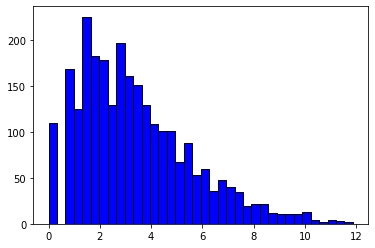

In [5]:
#Normalizing the distribution of the target variable likes 
df['likes']=np.log(df['likes']+1)
plt.hist(df['likes'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

In [6]:
#Creating predictors and target variable 
X=df [['score','rank','popularity','scored_by']]
y=df['likes']
y.replace([np.inf, -np.inf], np.nan, inplace=True)
y = y.fillna(0)

In [20]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)
model = LinearRegression()
print("Cross validation error on the train set (CV = 10): {}".format(np.sqrt(-cross_val_score(model, X, y, scoring = scorer, cv = 10)).mean()))
cross_val_score(model, X, y, scoring = scorer, cv = 10)
model.fit(X, y)
y_pred = model.predict(X)

Cross validation error on the train set (CV = 10): 0.9463206817956262


RMSE: 0.9122756366386134


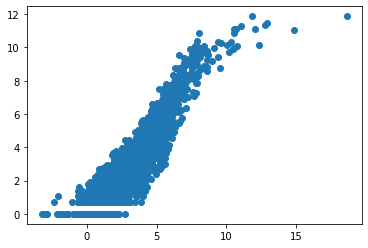

In [22]:
rmse_train = np.sqrt(mean_squared_error(y, y_pred))
print('RMSE: {}'.format(rmse_train))

plt.scatter(y_pred, y)
plt.show()

MSE: 0.5451727046682285


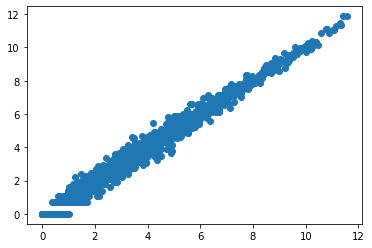

In [12]:
#2nd model with Random forest regressor 
model2 = RandomForestRegressor(n_estimators=20, random_state=0)
model2.fit(X, y)
y_pred = model2.predict(X)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model3, X, y, scoring='neg_mean_squared_error', cv=cv)
scores=absolute(scores)
# force scores to be positive
print('MSE: {}'.format(scores.mean()))
plt.scatter(y_pred, y)
plt.show()

MSE is : 0.545 


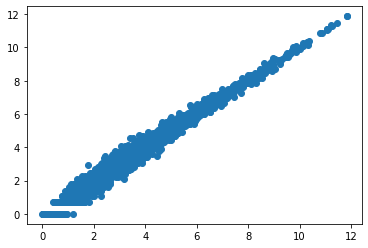

In [10]:
#3rd model with Extreme Gradient boosting 
model3=XGBRegressor()
model3.fit(X,y)
y_pred= model3.predict(X)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model3, X, y, scoring='neg_mean_squared_error', cv=cv)
# force scores to be positive
scores = absolute(scores)
print('MSE is : %.3f ' % (scores.mean()))

plt.scatter(y_pred,y)
plt.show()
